![qiskit_header.png](../../images/qiskit_header.png)

# Qiskit Aer: Pulse simulation of a backend model

This notebook shows how to use the Aer pulse simulator using a model generated from a backend. In particular, we run a Rabi experiment to find a $\pi$-pulse amplitude on a model of the Armonk one qubit backend, generated from the `FakeArmonk` mock backend.

## Table of contents

1) [Imports](#imports)


2) [Construct model from backend](#model)


3) [Run Rabi experiments and fit $\pi$-pulse amplitude](#rabi)

## 1. Imports <a name='imports'></a>

Import general libraries:

In [1]:
import numpy as np

Import Rabi experiment generator and fitter from Ignis, and other functions for job submission:

In [2]:
from qiskit.ignis.characterization.calibrations import rabi_schedules, RabiFitter

from qiskit.pulse import DriveChannel
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType

Import `PulseSimulator` and `PulseSystemModel` for pulse simulation, as well as the mock Armonk backend:

In [3]:
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel

# Mock Armonk backend
from qiskit.test.mock.backends.armonk.fake_armonk import FakeArmonk

## 2. Construct model from backend <a name='model'></a>

This section demonstrates the use of the `PulseSystemModel.from_backend` function for generating `PulseSystemModel` objects from a backend. 

**Note:** Currently not all system Hamiltonian information is available to the public, missing values have been replaced with $0$. As a result, in this notebook, we need to insert parameters into the backend object by hand. Specifically, we:
- Set the frequency of the qubit in the backend provided Hamiltonian to correspond with the backend provided estimate.
- Set the value of the drive strength to be consistent with a previously found $\pi$-pulse amplitude found on the actual Armonk device.

Instantiate mock backend:

In [4]:
armonk_backend = FakeArmonk()

Manual insertion of Hamiltonian parameters:

In [5]:
# set the drive strength from a previously inferred value for the real Armonk device
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['omegad0'] = 63455017.85

# set the qubit frequency from the estimate in the defaults
freq_est = armonk_backend.defaults().qubit_freq_est[0] / 10**9
armonk_backend.defaults().qubit_freq_est = [freq_est]
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['wq0'] = 2*np.pi*freq_est

Generate model from backend:

In [6]:
armonk_model = PulseSystemModel.from_backend(armonk_backend)

## 3. Run Rabi experiments and fit $\pi$-pulse amplitude <a name='rabi'></a>

Next, we run a Rabi experiments generated using Ignis on the simulator using the system model generated from the Armonk backend.

First, construct Rabi experiment schedules:

In [7]:
# qubit list
qubits = [0]

# drive amplitudes to use
num_exps = 64
drive_amps = np.linspace(0, 1.0, num_exps)

# drive shape parameters
drive_duration = 2048
drive_sigma = 256

# list of drive channels
drive_channels = [DriveChannel(0)]

# construct the schedules
rabi_schedules, xdata = rabi_schedules(amp_list=drive_amps, 
                                       qubits=qubits, 
                                       pulse_width=drive_duration, 
                                       pulse_sigma=drive_sigma,
                                       drives=drive_channels, 
                                       inst_map=armonk_backend.defaults().instruction_schedule_map, 
                                       meas_map=armonk_backend.configuration().meas_map)

Assemble the `qobj` for job submission. When assembling pulse schedules to be used with the pulse simulator, pass the `PulseSimulator` as the backend.

In [8]:
backend_sim = PulseSimulator()

rabi_qobj = assemble(rabi_schedules, 
                     backend=backend_sim,
                     meas_level=1, 
                     meas_return='avg',
                     shots=512)

Run the simulation:

In [9]:
sim_result = backend_sim.run(rabi_qobj, armonk_model).result()

Generate the Rabi oscillation plot:

Pi Amp: 0.347590


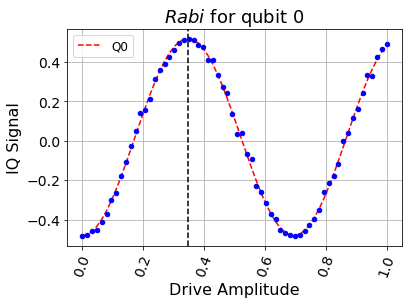

In [10]:
rabi_fit = RabiFitter(sim_result, xdata, qubits, fit_p0 = [1.5, 2, 0, 0])

# get the pi amplitude
pi_amp = rabi_fit.pi_amplitude(0)

# plot
rabi_fit.plot(0)
print('Pi Amp: %f'%pi_amp)

In [11]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright